<a href="https://colab.research.google.com/github/hisaom0419/my_python/blob/master/Tecan_saeki_OD_FL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/Colab Notebooks


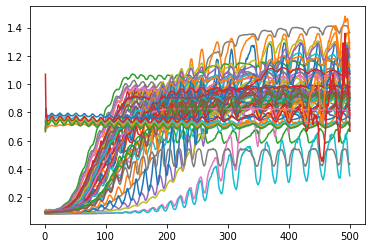

In [141]:
%pwd
%cd /content/drive/MyDrive/Colab Notebooks
#%ls

#Saeki edition-01
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import fftpack

data_file = 'mCherry-Kafri (1).xlsx' #データシート
max_cycle = 501 #最大読み取りサイクル数
sample_file = 'Sample_sheet_2.xlsx' #サンプルシート
graph_color = 'red' #グラフの色
graph_file = 'Graph_20210427.pdf' #グラフの保存ファイル名
max_FL_fime = 'maxRFP_file_20210427.xlsx' #最大蛍光値を保存するファイル

Sample = pd.read_excel(sample_file, index_col=0).to_dict()["Sample"]
length = len(Sample)

if length == 96:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=46,nrows=96,header=None,usecols=np.arange(0,max_cycle,1))
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=46+96,nrows=96,header=None,usecols=np.arange(0,max_cycle,1))
  
else:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=47,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=47+length+5,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))


#個別解析に使うサンプル名をインデックスにしたデータフレームの作成（周期検出とグラフ一覧作成には使わない）
df_1c = df_1.copy()
df_2c = df_2.copy()

df_1c['Sample'] = pd.read_excel(sample_file,index_col=0)
df_2c['Sample'] = pd.read_excel(sample_file,index_col=0)

df_1s = df_1c.sort_values('Sample').set_index('Sample')
df_2s = df_2c.sort_values('Sample').set_index('Sample')

#df_1をプロット
df_1s.T.plot(legend=0)

In [142]:
#周期（period）検出
#Saeki edition-02

Threshold = 0.1 #閾値を設定
Max_Cycle = 50 #最大サイクルを設定

df1 = df_1.T
all_period = []

for column_name in df1:
  f = df1[column_name].values 
  t = np.arange(len(f)) 

  assert t.size == f.size  # 時間軸の長さとデータの長さが同じであることを確認する
  assert np.unique(np.diff(t)).size == 1  # 時間間隔が全て一定であることを確認する

  T = (t[1] - t[0]) * t.size
  period = 1.0 / (np.arange(t.size / 2)[1:] / T)

  # パワースペクトル密度を計算
  f = f - np.average(f)         # 平均をゼロに。
  F = fftpack.fft(f)                          # 高速フーリエ変換
  Po = np.abs(F[1:(t.size // 2)]) ** 2 / T
  
  dominant_periods = [x for x in period[Po > Threshold] if x <= Max_Cycle]

  n=0
  for x in dominant_periods:
    all_period.append(dominant_periods[n])
    n=n+1

period = round(np.mean(all_period))
print('周期は',period,'です。')

周期は 35 です。


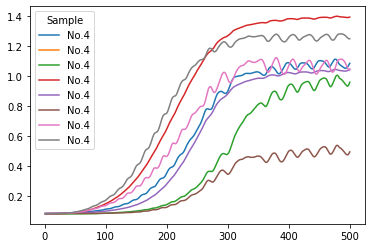

In [146]:
#サイクルを確認
Df =  df_1s.rolling(period,axis=1,center=True,min_periods=1).mean()
#Df.T.plot(legend=0)

Df.loc['No.4'].T.plot(legend=1)

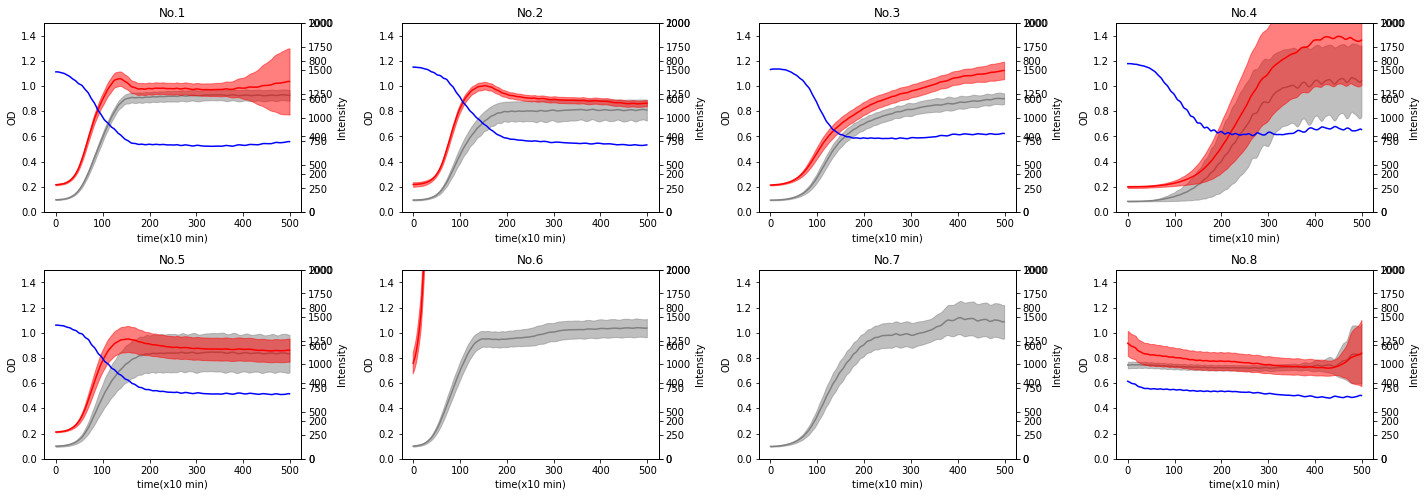

In [147]:
#グラフ一覧作成
#Saeki edition-03

#グラフの縦軸の最大値
max_OD = 1.5
max_FL = 1000

fig=plt.figure(figsize=(20,10))

#rollingの条件を変更
Df1 =  df_1.rolling(period,axis=1,center=True,min_periods=1).mean()
Df2 =  df_2.rolling(period,axis=1,center=True,min_periods=1).mean()
n=0
x=np.arange(len(Df1.T))

for sample in list(Sample.values())[:length//8]:#sortの問題で便宜上
  n+=1
  #wellを抽出
  wells = [k for k, v in Sample.items() if v == sample]
  tdf1=Df1.loc[wells]
  tdf2=Df2.loc[wells]

  y1=tdf1.mean(axis=0)
  std1=tdf1.std(axis=0)
  y2=tdf2.mean(axis=0)
  std2=tdf2.std(axis=0)
  y3=y2/y1

  ax1=fig.add_subplot(3,4,n)
  
  ax1.plot(x,y1,color="gray")
  ax1.fill_between(x,y1-std1,y1+std1,alpha=0.5,color="gray")
  ax1.set_title(sample)
  ax1.set_ylabel("OD")
  ax1.set_xlabel("time(x10 min)")
  ax1.set_ylim(0, max_OD)

  
  ax2 = ax1.twinx() #2軸のグラフを描くため
  ax2.plot(x,y2,color=graph_color)
  ax2.fill_between(x,y2-std2,y2+std2,alpha=0.5,color=graph_color)
  ax2.set_ylim(0, max_FL)
  #ax2.set_yticks(np.arange(0,2000+1,500))
  ax2.set_ylabel("Intensity")

  ax3 = ax1.twinx() #2軸のグラフを描くため
  ax3.plot(x,y3,color='blue')
  ax3.set_ylim(0, 2000)

plt.tight_layout()
plt.show()

#グラフを保存
fig.savefig(graph_file)

  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


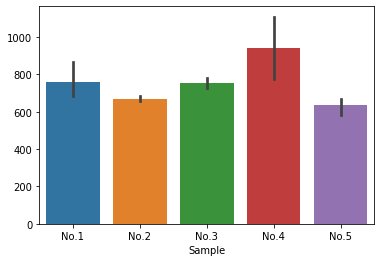

In [145]:
#蛍光最大値を取得、表示、ファイルに保存
s_maxFL = df_2s.rolling(period,axis=1,center=True,min_periods=1).mean().max(axis=1)
s_maxFL2 = s_maxFL['No.1':'No.5']

sns.barplot(s_maxFL2.index, s_maxFL2.values)


#df_maxFL.to_excel(max_FL_fime)

#移動平均のファイルを保存
# df_1s.T.rolling(period).mean().T.to_excel(ave_OD_file)
# df_2s.T.rolling(period).mean().T.to_excel(ave_GFP_file)

#M移動平均のファイルを保存(MGR算出用)
#Df1.to_csv(ave_OD_file)